In [11]:

import numpy as np

def calculate_number_clusters(nodes, base_station=(0, 0, 0), space_size=400):
    """
    Tính số cụm optimal theo công thức từ bài báo:
    K = √( / πd_tobs)
    
    nodes: tọa độ 3D của các node
    base_station: tọa độ base station (mặc định tại gốc tọa độ)
    """
    N = len(nodes)
    base_pos = np.array(base_station)
    
    # Tính khoảng cách trung bình từ các node đến base station
    distances = np.linalg.norm(nodes - base_pos, axis=1)
    d_tobs = np.mean(distances)
    
    # Áp dụng công thức K = √(N*L / πd_tobs)
    K_optimal = np.sqrt(N * space_size / (np.pi * d_tobs))
    K_optimal = max(1, int(np.round(K_optimal)))  # Đảm bảo K >= 1 và là số nguyên
    
    print(f"N = {N}, d_tobs = {d_tobs:.2f}, K_optimal = {K_optimal}")
    return K_optimal

In [ ]:

import numpy as np
from sklearn.cluster import KMeans

def split_isolated_nodes(clusters, r_sen=60, node_data=None):
    """
    Tách node dựa vào khoảng cách tới Cluster Head, không dùng tâm cụm.
    Node nào xa hơn r_sen → tách thành cụm riêng.
    """

    new_clusters = []

    for c in clusters:
        nodes = c["nodes"]
        ids = c["node_ids"]

        # Lấy cluster head thật sự (không phải center)
        head_id = choose_cluster_head(c, node_data)
        head_index = ids.index(head_id)
        head_pos = nodes[head_index]

        # Tính khoảng cách node tới cluster head
        dists = np.linalg.norm(nodes - head_pos, axis=1)

        # Node trong cụm hợp lệ (gần cluster head)
        in_cluster_idx = np.where(dists <= r_sen)[0]
        # Node bị tách vì xa head
        isolated_idx = np.where(dists > r_sen)[0]

        # Cụm giữ lại (có head và các node gần head)
        if len(in_cluster_idx) > 0:
            new_clusters.append({
                "node_ids": [ids[i] for i in in_cluster_idx],
                "nodes": nodes[in_cluster_idx],
                "center": np.mean(nodes[in_cluster_idx], axis=0),
                "node_data": {nid: c["node_data"][nid] for nid in [ids[i] for i in in_cluster_idx]},
                "cluster_head": head_id   # Lưu head luôn
            })

        # Node bị tách → mỗi node thành cụm riêng
        for i in isolated_idx:
            nid = ids[i]
            node = nodes[i]
            new_clusters.append({
                "node_ids": [nid],
                "nodes": np.array([node]),
                "center": node,
                "node_data": {nid: c["node_data"][nid]},
                "cluster_head": nid  # node lẻ tự làm head
            })

    return new_clusters



def cluster_split(nodes, node_ids, node_data=None, r_sen=60, R=150, max_depth=500, depth=0):
    """
    Hàm phân cụm đệ quy (Algorithm 1) + giữ danh tính node lẻ (isolated).
    """

    center = np.mean(nodes, axis=0)
    dists = np.linalg.norm(nodes - center, axis=1)

    # Điều kiện dừng
    if (len(nodes) <= R and np.all(dists <= r_sen)) or depth >= max_depth:
        return [{
            "node_ids": node_ids,
            "nodes": nodes,
            "center": center,
            "node_data": node_data if node_data else {}
        }]

    # weights for distance vs energy
    w_dist = 1
    w_energy = 0

    # coords -> chuẩn hóa theo phạm vi hiện tại trong cụm
    coords = nodes.astype(float)
    coord_scale = np.ptp(coords, axis=0).max()  # peak-to-peak của x,y,z
    if coord_scale <= 0:
        coords_norm = np.zeros_like(coords)
    else:
        coords_norm = coords / (coord_scale + 1e-9)

    # energy feature: lấy residual_energy từ node_data nếu có, else mặc định
    if node_data:
        energies = np.array([node_data.get(nid, {}).get('residual_energy', 100.0) for nid in node_ids], dtype=float)
    else:
        energies = np.full(len(node_ids), 100.0, dtype=float)

    # chuẩn hóa năng lượng và đảo chiều nếu muốn năng lượng cao => ưu tiên (giá trị nhỏ hơn)
    emin, emax = energies.min(), energies.max()
    if emax - emin < 1e-9:
        e_norm = np.full_like(energies, 0.5)
    else:
        e_norm = 1.0 - (energies - emin) / (emax - emin)  # in [0,1]; năng lượng lớn => giá trị nhỏ

    # ghép feature với trọng số (dùng sqrt để trọng số tương ứng dưới Euclidean)
    feat = np.hstack([
        coords_norm * np.sqrt(w_dist),
        e_norm.reshape(-1, 1) * np.sqrt(w_energy)
    ])

    # nếu không đủ mẫu để chia tiếp (1 node) thì gán nhãn 0
    if len(node_ids) < 2:
        labels = np.zeros(len(node_ids), dtype=int)
    else:
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        labels = kmeans.fit_predict(feat)

    clusters = []
    for i in range(2):
        sub_nodes = nodes[labels == i]
        sub_ids = [node_ids[j] for j in range(len(node_ids)) if labels[j] == i]

        sub_data = {nid: node_data[nid] for nid in sub_ids} if node_data else None

        clusters += cluster_split(sub_nodes, sub_ids, sub_data, r_sen, R, max_depth, depth + 1)

    # TÁCH NODE LẺ SAU KHI ĐỆ QUY
    clusters = split_isolated_nodes(clusters, r_sen=r_sen, node_data=node_data)

    return clusters


def choose_cluster_head(cluster, node_data):
    nodes = cluster["nodes"]
    center = cluster["center"]
    node_ids = cluster["node_ids"]

    dists_to_center = np.linalg.norm(nodes - center, axis=1)
    
    max_Q = -1
    best_cluster_head = node_ids[0]
    
    for i, node_id in enumerate(node_ids):
        if node_id in node_data:
            node_info = node_data[node_id]
            E_current = node_info.get('residual_energy', 100.0)
            E0 = node_info.get('initial_energy', 100.0)
            if E_current <= 0: E_current = 0.1

            ratio = E0 / E_current
            Q = dists_to_center[i] ** ratio

            if Q > max_Q:
                max_Q = Q
                best_cluster_head = node_id
    
    return best_cluster_head


In [19]:
#update

import numpy as np
from sklearn.cluster import KMeans




def calculate_objective_function(nodes, labels, centers):
    """
    Tính objective function T theo công thức (8)
    T = (sum of average distances within clusters) / (distance between two centers)
    """
    numerator = 0
    for i in range(2):
        cluster_nodes = nodes[labels == i]
        if len(cluster_nodes) > 0:
            distances = np.linalg.norm(cluster_nodes - centers[i], axis=1)
            numerator += np.sum(distances)
    
    denominator = np.linalg.norm(centers[0] - centers[1])
    
    if denominator == 0:
        return float('inf')
    
    T = numerator / denominator
    return T

def check_subgroup_threshold(nodes, r_sen):
    """
    Kiểm tra Definition 2: Subgroup threshold
    Khoảng cách Euclidean tối đa giữa hai node bất kỳ trong cụm <= r_sen
    
    Returns: True nếu thỏa mãn, False nếu không
    """
    if len(nodes) <= 1:
        return True
    
    # Tính khoảng cách giữa tất cả các cặp node
    max_distance = 0
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            dist = np.linalg.norm(nodes[i] - nodes[j])
            max_distance = max(max_distance, dist)
    
    return max_distance <= r_sen

def kmeans_with_best_T(nodes, N=30):
    """
    Thực hiện K-means N lần với các tâm khởi tạo ngẫu nhiên khác nhau
    và chọn kết quả có giá trị T nhỏ nhất
    """
    best_T = float('inf')
    best_labels = None
    best_centers = None
    
    for _ in range(N):
        kmeans = KMeans(n_clusters=2, n_init=1)
        labels = kmeans.fit_predict(nodes)
        centers = kmeans.cluster_centers_
        
        T = calculate_objective_function(nodes, labels, centers)
        
        if T < best_T:
            best_T = T
            best_labels = labels.copy()
            best_centers = centers.copy()
    
    return best_labels, best_centers, best_T

def cluster_split(nodes, node_ids, node_data=None, r_sen=60, R=20, N=30, max_depth=10, depth=0):
    """
    Hàm phân cụm lặp theo Algorithm 1 (K-Means Based Cluster Formation)
    
    nodes: tọa độ 3D của các node
    node_ids: list id tương ứng của các node
    node_data: dictionary chứa thông tin đầy đủ của nodes (bao gồm energy)
    r_sen: bán kính truyền tải tối đa (Rsep - subgroup threshold), default: 100m
    R: size threshold - số lượng node tối đa trong 1 cụm, default: 20
    N: số lần thực hiện clustering để chọn kết quả tốt nhất, default: 30
    max_depth: độ sâu đệ quy tối đa
    depth: độ sâu hiện tại
    """
    
    # Điều kiện dừng: Thỏa mãn CẢ HAI điều kiện
    # 1. Size threshold (Definition 3): len(nodes) <= R
    # 2. Subgroup threshold (Definition 2): max distance <= r_sen
    size_ok = len(nodes) <= R
    distance_ok = check_subgroup_threshold(nodes, r_sen)
    
    if (size_ok and distance_ok) or depth >= max_depth:
        center = np.mean(nodes, axis=0)
        return [{
            "node_ids": node_ids,
            "nodes": nodes,
            "center": center,
            "node_data": node_data if node_data else {}
        }]
    
    # Bước 2: Thực hiện K-means clustering N lần và chọn kết quả tốt nhất
    labels, centers, best_T = kmeans_with_best_T(nodes, N)
    
    # Bước 3: Phân chia thành các subgroups và đệ quy
    clusters = []
    for i in range(2):
        # Lọc nodes và node_ids theo label
        sub_nodes = nodes[labels == i]
        sub_ids = [node_ids[j] for j in range(len(node_ids)) if labels[j] == i]
        
        # Tạo sub_node_data cho cluster con
        sub_node_data = {}
        if node_data:
            for node_id in sub_ids:
                if node_id in node_data:
                    sub_node_data[node_id] = node_data[node_id]
        
        # Đệ quy cho subgroup
        clusters += cluster_split(sub_nodes, sub_ids, sub_node_data, r_sen, R, N, max_depth, depth + 1)
    
    return clusters


def choose_cluster_head(cluster_info, node_data=None):
    """
    Chọn cluster head dựa trên khoảng cách gần nhất với tâm cụm
    Hoặc dựa trên năng lượng cao nhất nếu có node_data
    
    cluster_info: dictionary chứa thông tin cụm
    node_data: dictionary chứa thông tin năng lượng của nodes
    """
    nodes = cluster_info["nodes"]
    center = cluster_info["center"]
    node_ids = cluster_info["node_ids"]
    
    if node_data and len(node_data) > 0:
        # Chọn node có năng lượng cao nhất
        max_energy = -1
        ch_id = node_ids[0]
        for nid in node_ids:
            if nid in node_data and "residual_energy" in node_data[nid]:
                if node_data[nid]["residual_energy"] > max_energy:
                    max_energy = node_data[nid]["residual_energy"]
                    ch_id = nid
        return ch_id
    else:
        # Chọn node gần tâm cụm nhất
        distances = np.linalg.norm(nodes - center, axis=1)
        min_idx = np.argmin(distances)
        return node_ids[min_idx]


N = 150, d_tobs = 345.47, K_optimal = 7
Số cụm: 7
Đã xuất file D:\Year 4\tiến hóa\project\data\output_data_kmeans\nodes_150.json


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18900\1646000036.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(clusters_output))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18900\1646000036.py:138: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


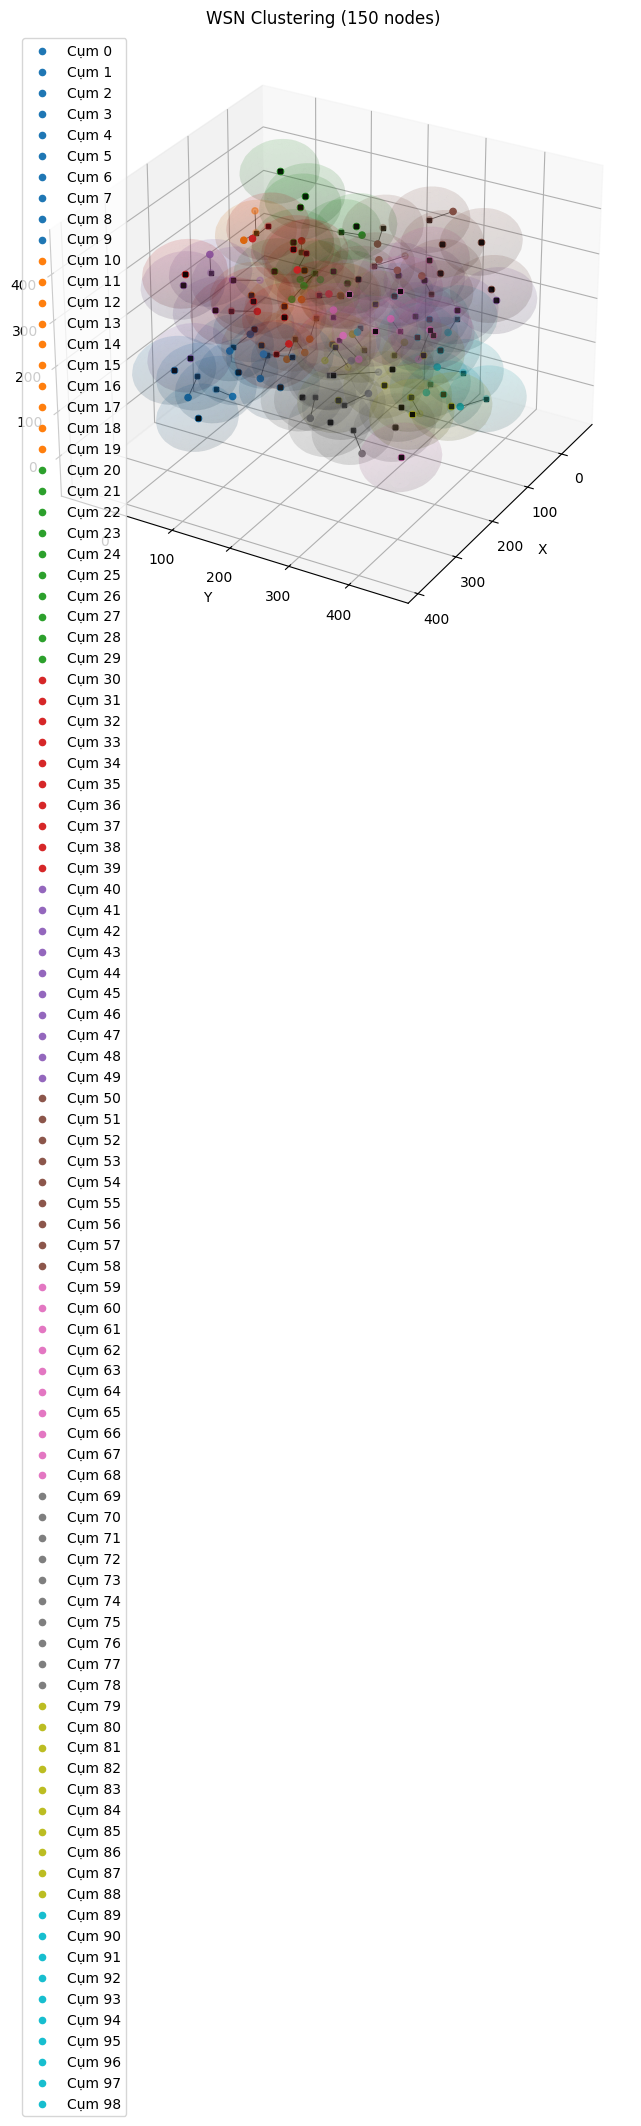

In [ ]:
###cell exe



import os
import json
import numpy as np


import matplotlib.pyplot as plt


from mpl_toolkits.mplot3d import Axes3D
import mplcursors
from PIL import Image






input_folder = "D:\\Year 4\\tiến hóa\\project\\data\\input_data_evenly_distributed"
output_folder = "D:\\Year 4\\tiến hóa\\project\\data\\output_data_kmeans"
os.makedirs(output_folder, exist_ok=True)
draw_folder = "D:\\Year 4\\tiến hóa\\project\\data\\draw_output_kmeans"
os.makedirs(draw_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.startswith("nodes_") and filename.endswith(".json"):
        # Lấy số lượng node từ tên file
        number_nodes = filename.split("_")[1].split(".")[0]
        # Đọc dữ liệu từ file input
        with open(os.path.join(input_folder, filename), "r") as f:
            data = json.load(f)
            node_data = {
                d["id"]: {
                    
                    "residual_energy": d["energy_residual"],   # năng lượng hiện tại
                    "initial_energy": d["energy_node"]     # năng lượng ban đầu
                }
                for d in data
            }
        #node_data = {d["id"]: d for d in data}
        node_positions = np.array([[d["x"], d["y"], d["z"]] for d in data])
        node_ids = [d["id"] for d in data]
        # Phân cụm
        k = calculate_number_clusters(node_positions, base_station=(0, 0, 0))
        print(f"Số cụm: {k}")
        clusters_raw = cluster_split(node_positions, node_ids, node_data, r_sen=60, R=int(number_nodes)//k, max_depth=10, depth=0)
        clusters_output = {}
        """assigned_nodes = set()
        for cluster_info in clusters_output.values():
            assigned_nodes.update(cluster_info['nodes'])"""
            
        # Tạo output
        
        for i, c in enumerate(clusters_raw):
            ch = choose_cluster_head(c, c["node_data"])
            clusters_output[i] = {
                "nodes": c["node_ids"],
                "center": tuple(np.round(c["center"], 2)),
                "cluster_head": int(ch)
            }
        # Xuất ra file
        out_path = os.path.join(output_folder, f"nodes_{number_nodes}.json")
        with open(out_path, "w") as f:
            json.dump(clusters_output, f, indent=4)
        print(f"Đã xuất file {out_path}")
        
        
        
        # Vẽ và lưu hình
        

        # --- VẼ VÀ HIỂN THỊ INTERACTIVE ---
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        colors = plt.cm.get_cmap('tab10', len(clusters_output))

        r_sen = 60  # sensing range sphere radius

        scatter_nodes = []    # lưu scatter object để hover
        node_info_map = []    # lưu thông tin node

        for cid, info in clusters_output.items():
            nodes = np.array([node_positions[nid] for nid in info['nodes']])
            ch_id = info['cluster_head']
            ch_pos = node_positions[ch_id]

            # --- VẼ MEMBER NODES ---
            scat = ax.scatter(
                nodes[:, 0], nodes[:, 1], nodes[:, 2],
                label=f'Cụm {cid}',
                color=colors(cid),
                s=20
            )
            scatter_nodes.append(scat)

            for nid in info['nodes']:
                pos = node_positions[nid]
                node_info_map.append((pos, node_data[nid]["residual_energy"]))

            # --- VẼ CLUSTER HEAD (vuông đen) ---
            ax.scatter(ch_pos[0], ch_pos[1], ch_pos[2], marker='s', s=10, color='black')
            node_info_map.append((ch_pos, node_data[ch_id]["residual_energy"]))

            # --- VẼ SPHERE MỜ ---
            u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:15j]
            x = ch_pos[0] + r_sen * np.cos(u) * np.sin(v)
            y = ch_pos[1] + r_sen * np.sin(u) * np.sin(v)
            z = ch_pos[2] + r_sen * np.cos(v)
            ax.plot_surface(x, y, z, rstride=1, cstride=1, alpha=0.08, color=colors(cid), shade=True)

            # --- VẼ ĐƯỜNG NỐI ---
            for pt in nodes:
                ax.plot(
                    [ch_pos[0], pt[0]],
                    [ch_pos[1], pt[1]],
                    [ch_pos[2], pt[2]],
                    'k-', linewidth=0.6, alpha=0.6
                )

        # --- HOVER TOOLTIP ---
        cursor = mplcursors.cursor(scatter_nodes, hover=True)
        @cursor.connect("add")
        def on_add(sel):
            x,y,z = sel.target
            for p,e in node_info_map:
                if np.allclose(p,(x,y,z)):
                    sel.annotation.set(text=f"({x:.1f},{y:.1f},{z:.1f})\nE={e:.2f}")
                    sel.annotation.get_bbox_patch().set(fc="white", alpha=0.8)
                    break

        # --- LABEL ---
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        ax.legend()
        plt.title(f'WSN Clustering ({number_nodes} nodes)')
        ax.view_init(elev=28, azim=30)
        plt.tight_layout()

        plt.show()   # <-- cho phép xoay bằng chuột

